In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from itertools import product

## Process data
Import the CSVs storing each experiment's results, put it together into a DataFrame, and compute some metrics

In [2]:
directory = 'outputs_case_0.9/'
outdir = 'figs/'

In [3]:
# Compute a 95% CI for the quantity Y/X

def ratio_of_means(x, y, sample_size):
    
    tee = t.ppf(0.975, sample_size-1)

    mean_x, mean_y = x.mean(axis=0), y.mean(axis=0)
    s_x, s_y, s_xy = x.std(axis=0), y.std(axis=0), x.cov(y)
    
    c_xx, c_yy = s_x**2 / (mean_x**2 * sample_size), s_y**2 / (mean_y**2 * sample_size)
    c_xy = s_xy / (mean_x * mean_y * sample_size)
    
    mid = 1-(tee**2)*c_xy
    half = tee*np.sqrt(c_xx + c_yy - 2*c_xy - tee**2 * (c_xx*c_yy - c_xy**2))
    scale = mean_y/(mean_x * (1-(tee**2)*c_xx))
    
    lower, upper = scale*(mid - half), scale*(mid+half)
    raw = mean_y/mean_x

    return [1 - raw, upper-raw, raw-lower]

def diff_of_means(x, y, sample_size):
    
    tee = t.ppf(0.975, sample_size-1)

    mean_x, mean_y = x.mean(axis=0), y.mean(axis=0)
    s_x, s_y = x.std(axis=0), y.std(axis=0)
    
    mid = mean_x - mean_y
    half = tee*np.sqrt(s_x**2/sample_size + s_y**2/sample_size)
    
    return [mid, half, half]

Compute the relative cost difference of using the fluid policy w/r/t the equilibrium policy and the simple policy.

In [4]:
all_dfs = []

times = []
param_settings = []
default_params = {
    'lambda' : 9.8,
    'nu' : 1/15,
    'mu' : 1/4,
    'h' : 0.2,
    'r' : 1.0,
    'C' : "lambda p: 10*1.0*(0.2-p)",
    'x_0' : 100,
    'y_0' : 100,
    'fluctuation': 0,
    'period': 1
}
with open(directory + "sims.log", "r") as logs:
    for line in logs.readlines():
        start = line.find("{")
        times.append(line[:start - 1])
        params = default_params.copy()
        params.update(eval(line[start:]))
        param_settings.append(params)

paths = sorted([file for file in os.listdir(directory) if file.endswith('.csv')])
for file, params in zip(paths, param_settings):
    df = pd.read_csv(directory + file, index_col=0)
    for param, val in params.items():
        df[param] = val
    all_dfs.append(df)

In [5]:
df = pd.concat(all_dfs).reset_index(drop=True)
df = df[df.h <= 3000]

In [6]:
df['init'] = [str(tup) for tup in zip(df['x_0'], df['y_0'])]
df.init.mask(df.x_0 == 43, 'Long-run', inplace=True)
df.drop(columns=['x_0', 'y_0'], inplace=True)

In [7]:
df['C_r_cost'] = df['C_cost'] + df['r_cost']
df['C_r_cost.1'] = df['C_cost.1'] + df['r_cost.1']
df['C_r_cost.2'] = df['C_cost.2'] + df['r_cost.2']

In [8]:
# df['M'] = df['C'].str[14:-11].astype(float) if typ == 'quad' else df['C'].str[13:-8].astype(float)
# df.drop(columns=['C'], inplace=True)

In [9]:
groupers = ['scale', 'init', 'lambda', 'nu', 'h', 'M', 'period', 'fluctuation']
grouped = df.groupby(by=groupers)#, as_index=False)

In [10]:
stat = 'total_cost'

In [11]:
raw_eq_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat], x[stat + '.2'], len(x))[0])
below_eq_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat], x[stat + '.2'], len(x))[1])
above_eq_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat], x[stat + '.2'], len(x))[2])

raw_simple_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[0])
below_simple_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[1])
above_simple_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat+ '.1'], x[stat + '.2'], len(x))[2])

In [12]:
raw_eq = grouped.apply(lambda x: diff_of_means(x[stat], x[stat + '.2'], len(x))[0]) / grouped.run_length.mean()
below_eq = grouped.apply(lambda x: diff_of_means(x[stat], x[stat + '.2'], len(x))[1]) / grouped.run_length.mean()
above_eq = grouped.apply(lambda x: diff_of_means(x[stat], x[stat + '.2'], len(x))[2]) / grouped.run_length.mean()

raw_simple = grouped.apply(lambda x: diff_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[0]) / grouped.run_length.mean()
below_simple = grouped.apply(lambda x: diff_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[1]) / grouped.run_length.mean()
above_simple = grouped.apply(lambda x: diff_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[2]) / grouped.run_length.mean()

In [13]:
q_eq = grouped['h_cost'].mean() / (grouped.run_length.mean() * grouped.h.mean())
q_ci_eq = 1.96 * grouped['h_cost'].std() / (grouped.run_length.mean() * grouped.h.mean() * np.sqrt(grouped.size()))

q_simple = grouped['h_cost.1'].mean() / (grouped.run_length.mean() * grouped.h.mean())
q_ci_simple = 1.96 * grouped['h_cost.1'].std() / (grouped.run_length.mean() * grouped.h.mean() * np.sqrt(grouped.size()))

q_opt = grouped['h_cost.2'].mean() / (grouped.run_length.mean() * grouped.h.mean())
q_ci_opt = 1.96 * grouped['h_cost.2'].std() / (grouped.run_length.mean() * grouped.h.mean() * np.sqrt(grouped.size()))

In [14]:
hcost_eq = grouped['h_cost'].mean() / grouped.run_length.mean()
hcost_ci_eq = 1.96 * grouped['h_cost'].std() / (grouped.run_length.mean() * np.sqrt(grouped.size()))
hcost_simple = grouped['h_cost.1'].mean() / grouped.run_length.mean()
hcost_ci_simple = 1.96 * grouped['h_cost.1'].std() / (grouped.run_length.mean() * np.sqrt(grouped.size()))
hcost_opt = grouped['h_cost.2'].mean() / grouped.run_length.mean()
hcost_ci_opt = 1.96 * grouped['h_cost.2'].std() / (grouped.run_length.mean() * np.sqrt(grouped.size()))

Ccost_eq = grouped['C_cost'].mean() / grouped.run_length.mean()
Ccost_ci_eq = 1.96 * grouped['C_cost'].std() / (grouped.run_length.mean() * np.sqrt(grouped.size()))
Ccost_simple = grouped['C_cost.1'].mean() / grouped.run_length.mean()
Ccost_ci_simple = 1.96 * grouped['C_cost.1'].std() / (grouped.run_length.mean() * np.sqrt(grouped.size()))
Ccost_opt = grouped['C_cost.2'].mean() / grouped.run_length.mean()
Ccost_ci_opt = 1.96 * grouped['C_cost.2'].std() / (grouped.run_length.mean() * np.sqrt(grouped.size()))

rcost_eq = grouped['r_cost'].mean() / grouped.run_length.mean()
rcost_ci_eq = 1.96 * grouped['r_cost'].std() / (grouped.run_length.mean() * np.sqrt(grouped.size()))
rcost_simple = grouped['r_cost.1'].mean() / grouped.run_length.mean()
rcost_ci_simple = 1.96 * grouped['r_cost.1'].std() / (grouped.run_length.mean() * np.sqrt(grouped.size()))
rcost_opt = grouped['r_cost.2'].mean() / grouped.run_length.mean()
rcost_ci_opt = 1.96 * grouped['r_cost.2'].std() / (grouped.run_length.mean() * np.sqrt(grouped.size()))

In [15]:
cr_eq = grouped['C_r_cost'].mean() / grouped.run_length.mean()
cr_ci_eq = 1.96 * grouped['C_r_cost'].std() / (grouped.run_length.mean() * np.sqrt(grouped.size()))

cr_simple = grouped['C_r_cost.1'].mean() / grouped.run_length.mean()
cr_ci_simple = 1.96 * grouped['C_r_cost.1'].std() / (grouped.run_length.mean() * np.sqrt(grouped.size()))

cr_opt = grouped['C_r_cost.2'].mean() / (grouped.run_length.mean())
cr_ci_opt = 1.96 * grouped['C_r_cost.2'].std() / (grouped.run_length.mean() * np.sqrt(grouped.size()))

In [16]:
p_eq = grouped['mean_p'].mean()
p_ci_eq = 1.96 * grouped['mean_p'].std() / np.sqrt(grouped.size())
p_simple = grouped['mean_p.1'].mean()
p_ci_simple = 1.96 * grouped['mean_p.1'].std() / np.sqrt(grouped.size())
p_opt = grouped['mean_p.2'].mean()
p_ci_opt = 1.96 * grouped['mean_p.2'].std() / np.sqrt(grouped.size())

In [17]:
cong_time_eq = grouped['mean_congested_time'].mean()
cong_time_ci_eq = 1.96 * grouped['mean_congested_time'].std() / np.sqrt(grouped.size())
cong_time_simple = grouped['mean_congested_time.1'].mean()
cong_time_ci_simple = 1.96 * grouped['mean_congested_time.1'].std() / np.sqrt(grouped.size())
cong_time_opt = grouped['mean_congested_time.2'].mean()
cong_time_ci_opt = 1.96 * grouped['mean_congested_time.2'].std() / np.sqrt(grouped.size())

In [18]:
p_time_eq = grouped['mean_p_time'].mean()
p_time_ci_eq = 1.96 * grouped['mean_p_time'].std() / np.sqrt(grouped.size())
p_time_simple = grouped['mean_p_time.1'].mean()
p_time_ci_simple = 1.96 * grouped['mean_p_time.1'].std() / np.sqrt(grouped.size())
p_time_opt = grouped['mean_p_time.2'].mean()
p_time_ci_opt = 1.96 * grouped['mean_p_time.2'].std() / np.sqrt(grouped.size())

In [19]:
opt_mean = grouped[stat + '.2'].mean() / grouped.run_length.mean()
opt_ci = 1.96 * grouped[stat + '.2'].std() / np.sqrt(grouped.size()) / grouped.run_length.mean()
eq_mean = grouped[stat].mean() / grouped.run_length.mean()
eq_ci = 1.96 * grouped[stat].std() / np.sqrt(grouped.size()) / grouped.run_length.mean()
simple_mean = grouped[stat + '.1'].mean() / grouped.run_length.mean()
simple_ci = 1.96 * grouped[stat + '.1'].std() / np.sqrt(grouped.size()) / grouped.run_length.mean()

In [20]:
new_df = pd.concat([raw_eq, below_eq, above_eq,
                    raw_simple, below_simple, above_simple,
                    raw_eq_rel, below_eq_rel, above_eq_rel,
                    raw_simple_rel, below_simple_rel, above_simple_rel,#],
                    q_eq, q_ci_eq, q_simple, q_ci_simple, q_opt, q_ci_opt,
                    cr_eq, cr_ci_eq, cr_simple, cr_ci_simple, cr_opt, cr_ci_opt,
                    hcost_eq, hcost_ci_eq, hcost_simple, hcost_ci_simple, hcost_opt, hcost_ci_opt,
                    Ccost_eq, Ccost_ci_eq, Ccost_simple, Ccost_ci_simple, Ccost_opt, Ccost_ci_opt,
                    rcost_eq, rcost_ci_eq, rcost_simple, rcost_ci_simple, rcost_opt, rcost_ci_opt,
                    opt_mean, opt_ci, eq_mean, eq_ci, simple_mean, simple_ci,
                    p_eq, p_ci_eq, p_simple, p_ci_simple, p_opt, p_ci_opt,
                    p_time_eq, p_time_ci_eq, p_time_simple, p_time_ci_simple, p_time_opt, p_time_ci_opt,
                    cong_time_eq, cong_time_ci_eq, cong_time_simple, cong_time_ci_simple, cong_time_opt, cong_time_ci_opt,
                   ],
                   axis=1).reset_index()
groupers[2] = 'rate'
new_df.columns = groupers + [
                  'raw_eq', 'below_eq', 'above_eq', 'raw_simple', 'below_simple', 'above_simple',
                  'raw_eq_rel', 'below_eq_rel', 'above_eq_rel', 'raw_simple_rel', 'below_simple_rel', 'above_simple_rel',#]
                  'q_eq', 'q_ci_eq', 'q_simple', 'q_ci_simple', 'q_opt', 'q_ci_opt',
                  'cr_eq', 'cr_ci_eq', 'cr_simple', 'cr_ci_simple', 'cr_opt', 'cr_ci_opt',
                  'hcost_eq', 'hcost_ci_eq', 'hcost_simple', 'hcost_ci_simple', 'hcost_opt', 'hcost_ci_opt',
                  'Ccost_eq', 'Ccost_ci_eq', 'Ccost_simple', 'Ccost_ci_simple', 'Ccost_opt', 'Ccost_ci_opt',
                  'rcost_eq', 'rcost_ci_eq', 'rcost_simple', 'rcost_ci_simple', 'rcost_opt', 'rcost_ci_opt',
                  'opt_mean', 'opt_ci', 'eq_mean', 'eq_ci', 'simple_mean', 'simple_ci',
                  'p_eq', 'p_ci_eq', 'p_simple', 'p_ci_simple', 'p_opt', 'p_ci_opt',
                  'p_time_eq', 'p_time_ci_eq', 'p_time_simple', 'p_time_ci_simple', 'p_time_opt', 'p_time_ci_opt',
                  'cong_time_eq', 'cong_time_ci_eq', 'cong_time_simple', 'cong_time_ci_simple', 'cong_time_opt', 'cong_time_ci_opt'
                 ]

In [21]:
new_df.to_csv('df_lighter.csv')

## Plotting
Isolate the effect of each parameter: hold all others fixed (i.e. group by the other parameters, and then analyze each group separately), and plot against the parameter being varied.

In [22]:
grays = ['green', 'teal', 'blue', 'black']
# grays = ['black']

In [23]:
rates = sorted(new_df.rate.unique())
scales = sorted(new_df.scale.unique())
hs = sorted(new_df.h.unique())
Ms = sorted(new_df.M.unique())
inits = sorted(new_df.init.unique())

fluctuations = sorted(new_df.fluctuation.unique())
periods = sorted(new_df.period.unique())

### Tradeoff

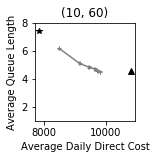

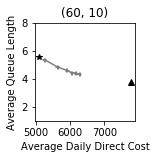

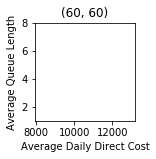

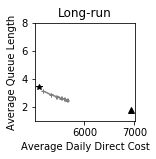

In [39]:
for init in inits:
    fig, ax = plt.subplots()
    subset = new_df[(new_df['init'] == init)].sort_values(by='h')
    ax.errorbar(subset.cr_opt, subset.q_opt, xerr=subset.cr_ci_opt, yerr=subset.q_ci_opt, capsize=2, color='grey')
    ax.set_title(init)
    ax.set_xlabel("Average Daily Direct Cost")
    ax.set_ylabel(r"Average Queue Length")
    
    ax.errorbar(subset.cr_eq.mean(), subset.q_eq.mean(),
                xerr=subset.cr_ci_eq.mean()/np.sqrt(5), yerr=subset.q_ci_eq.mean()/np.sqrt(5),
               marker='*', color='black', markersize=6)
    ax.errorbar(subset.cr_simple.mean(), subset.q_simple.mean(),
                xerr=subset.cr_ci_simple.mean()/np.sqrt(5), yerr=subset.q_ci_simple.mean()/np.sqrt(5),
               marker='^', color='black', markersize=6)
    
    fig.set_figwidth(2)
    fig.set_figheight(2)
    fig.subplots_adjust(left=0.2)
    fig.subplots_adjust(bottom=0.2)
    plt.ylim([1, 8])
    
    plt.savefig(outdir + "frontier_{}.pdf".format(init))#, bbox_inches='tight')

### Queue Length

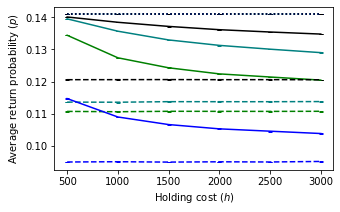

In [25]:
fig, ax = plt.subplots()

for i, init in enumerate(inits):
    
    subset = new_df[(new_df['init'] == init)].sort_values(by='h')
    
    ax.errorbar(subset['h'], subset.p_eq, yerr=subset.p_ci_eq,
                capsize=2, linestyle=":", label="Equilibrium", color=grays[i])

    ax.errorbar(subset['h'], subset.p_simple, yerr=subset.p_ci_simple,
                capsize=2, linestyle="--", label="Simple", color=grays[i])

    ax.errorbar(subset['h'], subset.p_opt, yerr=subset.p_ci_opt,
                capsize=2, label="Fluid", color=grays[i])

    ax.set_ylabel("Average return probability ($p$)")
    ax.set_xlabel(r"Holding cost ($h$)")

    fig.set_figheight(3)
    fig.set_figwidth(5)

# plt.savefig(outdir + "q.pdf", bbox_inches='tight')

0    8488.862263
1    9155.752093
2    9449.311097
3    9639.280985
4    9728.802702
5    9816.983639
Name: cr_opt, dtype: float64 0    10.219996
1    11.576970
2    12.218970
3    12.550385
4    12.623238
5    12.854245
Name: cr_ci_opt, dtype: float64
6     5243.236288
7     5617.687570
8     5894.634763
9     6046.739783
10    6163.102945
11    6269.276583
Name: cr_opt, dtype: float64 6      7.284227
7      9.519337
8     10.390321
9     10.770286
10    11.159521
11    11.517503
Name: cr_ci_opt, dtype: float64
12    10890.436099
13    11478.747607
14    11718.868004
15    11868.557294
16    11934.784885
17    12017.739348
Name: cr_opt, dtype: float64 12    13.691472
13    14.276981
14    14.516295
15    14.490072
16    14.312646
17    14.363690
Name: cr_ci_opt, dtype: float64
18    5178.077235
19    5333.559928
20    5446.342631
21    5541.262195
22    5609.931912
23    5662.879105
Name: cr_opt, dtype: float64 18    5.084740
19    6.378187
20    6.950072
21    7.422352
22    7.606674

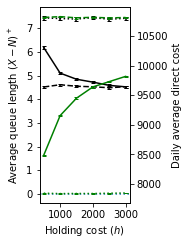

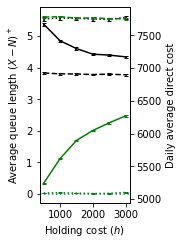

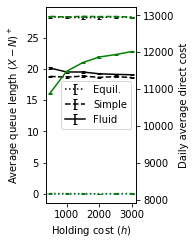

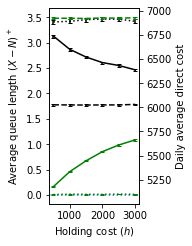

In [26]:
for i, init in enumerate(inits):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    subset = new_df[(new_df['init'] == init)].sort_values(by='h')
    
    ax1.errorbar(subset['h'], subset.q_eq, yerr=subset.q_ci_eq,
                capsize=2, linestyle=":", label="Equil.", color=grays[-1])
    ax1.errorbar(subset['h'], subset.q_simple, yerr=subset.q_ci_simple,
                capsize=2, linestyle="--", label="Simple", color=grays[-1])
    ax1.errorbar(subset['h'], subset.q_opt, yerr=subset.q_ci_opt,
                capsize=2, label="Fluid", color=grays[-1])
    
    ax2.errorbar(subset['h'], subset.cr_eq, yerr=subset.cr_ci_eq,
                capsize=2, linestyle=":", label="Equil.", color=grays[0])
    ax2.errorbar(subset['h'], subset.cr_simple, yerr=subset.cr_ci_simple,
                capsize=2, linestyle="--", label="Simple", color=grays[0])
    ax2.errorbar(subset['h'], subset.cr_opt, yerr=subset.cr_ci_opt,
                capsize=2, label="Fluid", color=grays[0])

    print(subset.cr_opt, subset.cr_ci_opt)
    
    ax1.set_ylabel(r"Average queue length $(X-N)^+$")
    # ax2.set_ylabel(r"Daily average int. + re-admit. cost")
    ax2.set_ylabel(r"Daily average direct cost")
    ax1.set_xlabel(r"Holding cost ($h$)")
    if i == 2:
        ax1.legend()
    
    ax1.axhline(0, linestyle=':')

    fig.set_figwidth(2.5)
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.gcf().subplots_adjust(left=0.2)
    plt.gcf().subplots_adjust(right=0.7)

    plt.savefig(outdir + "tradeoff_{}.pdf".format(init))#, bbox_inches='tight')

0    7.432637
1    7.405301
2    7.383345
3    7.445345
4    7.375453
5    7.416897
Name: q_eq, dtype: float64
0    6.179122
1    5.100969
2    4.842253
3    4.719990
4    4.583902
5    4.521579
Name: q_opt, dtype: float64
6     5.546795
7     5.577882
8     5.569558
9     5.547334
10    5.536804
11    5.594301
Name: q_eq, dtype: float64
6     5.378570
7     4.854016
8     4.607986
9     4.430517
10    4.401455
11    4.345224
Name: q_opt, dtype: float64
12    28.286042
13    28.230034
14    28.178977
15    28.191607
16    28.318183
17    28.196298
Name: q_eq, dtype: float64
12    20.120628
13    19.499550
14    19.488782
15    19.207021
16    19.111417
17    19.050758
Name: q_opt, dtype: float64
18    3.407643
19    3.420514
20    3.452406
21    3.467133
22    3.461353
23    3.421763
Name: q_eq, dtype: float64
18    3.129277
19    2.868066
20    2.715971
21    2.606828
22    2.550160
23    2.464023
Name: q_opt, dtype: float64


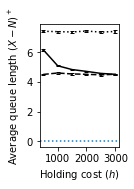

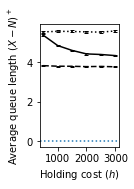

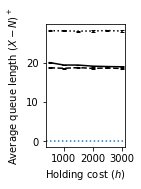

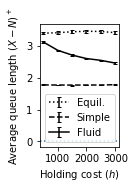

In [27]:
for i, init in enumerate(inits):
    fig, ax = plt.subplots()
    
    subset = new_df[(new_df['init'] == init)].sort_values(by='h')
    
    ax.errorbar(subset['h'], subset.q_eq, yerr=subset.q_ci_eq,
                capsize=2, linestyle=":", label="Equil.", color=grays[-1])

    ax.errorbar(subset['h'], subset.q_simple, yerr=subset.q_ci_simple,
                capsize=2, linestyle="--", label="Simple", color=grays[-1])

    ax.errorbar(subset['h'], subset.q_opt, yerr=subset.q_ci_opt,
                capsize=2, label="Fluid", color=grays[-1])
    
    print(subset.q_eq)
    print(subset.q_opt)

    ax.set_ylabel(r"Average queue length $(X-N)^+$")
    ax.set_xlabel(r"Holding cost ($h$)")
    if i == 3:
        ax.legend()
    
    ax.axhline(0, linestyle=':')

    fig.set_figheight(2.5)
    fig.set_figwidth(2)
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.gcf().subplots_adjust(left=0.35)


    plt.savefig(outdir + "q_{}.pdf".format(init))#, bbox_inches='tight')

## Performance Plot

### Line styles:
- Solid: fluid policy vs equilibrium policy
- Dot/dash: fluid safety policy vs equilbirium policy
- Dash: fluid policy vs simple policy
- Dot: fluid safety policy vs simple policy

In [28]:
new_df[new_df.init == 'Long-run'][['raw_eq_rel', 'raw_simple_rel']]

,raw_eq_rel,raw_simple_rel
18,0.848162,13.674674
19,3.746119,5.682562
20,7.368298,0.589256
21,10.620126,-2.701576
22,12.862829,-5.536962
23,15.028607,-6.319689


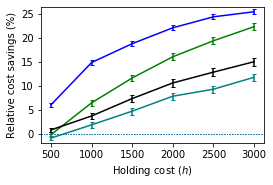

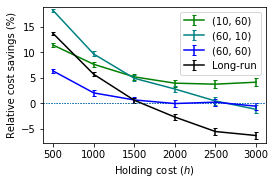

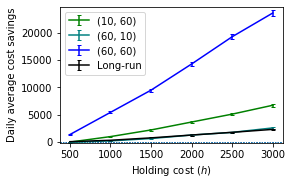

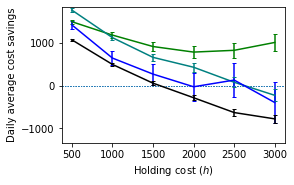

In [29]:
# Plot separately, for export

xlabel = r"Holding cost ($h$)"
xvar = "h"

ylabels = {
    'eq_rel' : "Relative cost savings (%)",
    'simple_rel' : "Relative cost savings (%)",
    'eq' : "Daily average cost savings",
    'simple' : "Daily average cost savings"
}
ylims = {
    var_name : [(new_df['raw_{}'.format(var_name)] - 2*new_df['below_{}'.format(var_name)]).min(),
              (new_df['raw_{}'.format(var_name)] + 2*new_df['above_{}'.format(var_name)]).max()] \
    for var_name in ylabels
}


def save_errorbars(data, var_name, fig_name, legend=False):
    
    fig, ax = plt.subplots()
    for j, init in enumerate(inits):
        subset = data[data.init == init].sort_values(by=xvar)
        ax.errorbar(subset[xvar], subset['raw_{}'.format(var_name)],
                    yerr=[subset['below_{}'.format(var_name)], subset['above_{}'.format(var_name)]],
                   capsize=2,
                   color=grays[j],
                   label=init)
        plt.ylim(ylims[var_name])
        ax.axhline(0, linewidth=1, linestyle='dotted')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabels[var_name])
        
        if legend:
            ax.legend()
            
        fig.set_figheight(2.5)
        fig.set_figwidth(4)
            
        plt.savefig(outdir + 'case_{}_{}.pdf'.format(var_name, fig_name), bbox_inches='tight')

for i, val in enumerate(Ms):
    fig_name = 'cost_{}'.format(val)
    bigset = new_df
    save_errorbars(bigset, 'eq_rel', fig_name, False)
    save_errorbars(bigset, 'simple_rel', fig_name, True)
    save_errorbars(bigset, 'eq', fig_name, True)
    save_errorbars(bigset, 'simple', fig_name)

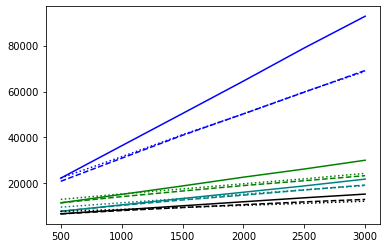

In [30]:
flat = grouped.mean().reset_index()
for i, init in enumerate(inits):
    tmp = flat[flat.init == init].sort_values(by='h')
    plt.plot(tmp.h, tmp['total_cost']/tmp.run_length, color=grays[i])
    plt.plot(tmp.h, tmp['total_cost.1']/tmp.run_length, linestyle=':', color=grays[i])
    plt.plot(tmp.h, tmp['total_cost.2']/tmp.run_length, linestyle='--', color=grays[i])

In [31]:
# # Plot all together, for Python interpretation
# fig, axes = plt.subplots(1, len(Ms), sharey=True)
# for i, M in enumerate(Ms):
#     ax = axes[i]
#     for j, init in enumerate(inits):
#         subset = new_df[(new_df.M == M) & (new_df.init==init)].sort_values(by='h')
#         ax.errorbar(subset.h, subset.raw_eq_rel, yerr=[subset.below_eq_rel, subset.above_eq_rel],
#                     capsize=2,
#                     color=grays[j],
#                     label=init)
#     ax.axhline(0, linewidth=1, linestyle='dotted')
#     ax.set_xlabel(r"Holding cost ($h$)")
#     ax.set_ylabel("Relative cost savings (%)")
#     ax.title.set_text(r"$M$={}".format(M))
#     if i == 0:
#         ax.legend()

    
# fig.set_figheight(2.5)
# fig.set_figwidth(10)

In [32]:
# ## Plot all together, for Python interpretation
# fig, axes = plt.subplots(1, len(Ms), sharey=True)
# for i, M in enumerate(Ms):
#     ax = axes[i]
#     for j, init in enumerate(inits):
#         subset = new_df[(new_df.M == M) & (new_df.init==init)].sort_values(by='h')
#         ax.errorbar(subset.h, subset.raw_simple_rel, yerr=[subset.below_simple_rel, subset.above_simple_rel],
#                     capsize=2,
#                     color=grays[j],
#                     label=init)
#     ax.axhline(0, linewidth=1, linestyle='dotted')
#     ax.set_xlabel(r"Holding cost ($h$)")
#     ax.set_ylabel("Relative cost savings (%)")
#     ax.title.set_text(r"$M$={}".format(M))
#     if i == 0:
#         ax.legend()

    
# fig.set_figheight(2.5)
# fig.set_figwidth(10)